In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cpi
import datetime
import seaborn as sns

In [3]:
# read in data
df = pd.read_csv('cleaned_data.csv')

# list all column names without ...
pd.set_option('display.max_columns', None)
df.head()

# Reporting Railroad Name, Accident Year, Accident Number, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name,
# Maintenance Accident Year, Maintenance Accident Month, Maintenance Accident Number, Grade Crossing ID, Date, Subdivision, Division Code, Division, State Abbreviation,
# Track Name, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3, 
# First Car Initials, First Car Number, Causing Car Initials, Causing Car Number, Narrative, Incident Key, Report Key, Reporting Railroad SMT Grouping,
# Other Railroad SMT Grouping, Maintenance Railroad SMT Grouping, Reporting Railroad SMT Grouping Name, Other Railroad SMT Grouping Name, Maintenance Railroad SMT Grouping,

C:\Users\Gian\AppData\Local\Temp\ipykernel_7560\689264397.py:2: DtypeWarning: Columns (21,22,36,37,46,47,48,49,50,51,52,53,54,56,110,111,112,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


,Reporting Railroad Name,Report Year,Accident Number,Accident Year,Accident Month,Other Railroad Name,Other Accident Number,Other Accident Year,Other Accident Month,Maintenance Railroad Name,Maintenance Accident Number,Maintenance Accident Year,Maintenance Accident Month,Grade Crossing ID,Day,Date,Time,Accident Type,Hazmat Cars,Hazmat Cars Damaged,Hazmat Released Cars,Persons Evacuated,Subdivision,Division Code,Division,Station,Milepost,State Abbreviation,State Name,County Name,District,Temperature,Visibility,Weather Condition,Track Type,Track Name,Track Class,Track Density,Train Direction,Equipment Type,Equipment Attended,Train Number,Train Speed,Recorded Estimated Speed,Maximum Speed,Gross Tonnage,Signalization,Method of Operation,Adjunct Code 1,Adjunct Code Name 1,Adjunct Code 2,Adjunct Code Name 2,Adjunct Code 3,Adjunct Code Name 3,Remote Control Locomotive,First Car Initials,First Car Number,First Car Position,First Car Loaded,Causing Car Initials,Causing Car Number,Causing Car Position,Causing Car Loaded,Positive Alcohol Tests,Positive Drug Tests,Passengers Transported,Head End Locomotives,Mid Train Manual Locomotives,Mid Train Remote Locomotives,Rear End Manual Locomotives,Rear End Remote Locomotives,Derailed Head End Locomotives,Derailed Mid Train Manual Locomotives,Derailed Mid Train Remote Locomotives,Derailed Rear End Manual Locomotives,Derailed Rear End Remote Locomotives,Loaded Freight Cars,Loaded Passenger Cars,Empty Freight Cars,Empty Passenger Cars,Cabooses,Derailed Loaded Freight Cars,Derailed Loaded Passenger Cars,Derailed Empty Freight Cars,Derailed Empty Passenger Cars,Derailed Cabooses,Equipment Damage Cost,Track Damage Cost,Total Damage Cost,Primary Accident Cause,Contributing Accident Cause,Engineers On Duty,Firemen On Duty,Conductors On Duty,Brakemen On Duty,Hours Engineers On Duty,Minutes Engineers On Duty,Hours Conductors On Duty,Minutes Conductors On Duty,Railroad Employees Killed,Railroad Employees Injured,Passengers Killed,Passengers Injured,Others Killed,Others Injured,Persons Killed For Reporting Railroad,Persons Injured For Reporting Railroad,Total Persons Killed,Total Persons Injured,Total Killed Form 54,Total Injured Form 54,Special Study 1,Special Study 2,Latitude,Longitude,Narrative,Joint Track Type,Joint Track Class,Class,Joint CD,Incident Key,Report Key,Reporting Railroad Company Grouping,Reporting Railroad Class,Reporting Railroad SMT Grouping,Reporting Parent Railroad Company Name,Reporting Railroad Holding Company,Other Railroad Company Grouping,Other Railroad Class,Other Railroad SMT Grouping,Other Parent Railroad Company Name,Other Railroad Holding Company,Maintenance Railroad Company Grouping,Maintenance Railroad Class,Maintenance Railroad SMT Grouping,Maintenance Parent Railroad Company Name,Maintenance Railroad Holding Company
0,Northern Indiana Commuter Transportation District,2017.0,N1700013,17.0,6.0,NaN,NaN,NaN,NaN,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,201707188,17.0,6.0,NaN,6.0,06/06/2017,2:14 PM,Derailment,0.0,0.0,0.0,149,SYSTEM,NaN,NaN,CHICAGO,.55,IL,ILLINOIS,COOK,4.0,65.0,Day,Clear,Yard,YARD LEAD,1,NaN,North,Commuter Train - Pulling,Yes,918,10.0,Estimated,10,0,Not Signaled,Other Than Main Track,NaN,NaN,NaN,NaN,NaN,NaN,Not a remotely controlled operation,NICD,000203,2.0,No,NaN,NaN,0.0,NaN,0.0,0.0,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,"98,627",0,"132,013",Switch point worn or broken,NaN,1.0,NaN,1.0,NaN,1.0,56.0,1.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,OTH,000-000-000,41.884035,-87.623003,TRAIN 918 (NICD WB TRAIN 18) DERAILED WHILE PA...,Yard,1,No,1.0,NIRC201707188201706,NICDN1700013201706,Passenger (Formerly Commuter),Class 3,SMT-4 - CP/CN/CCD,Northern Indiana Commuter Transportation District,Not Assigned,NaN,NaN,NaN,NaN,NaN,Passenger (Formerly Commuter),Class 3,SMT-4 - CP/CN/CCD,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,Not Assigned
1,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,2017.0,201707

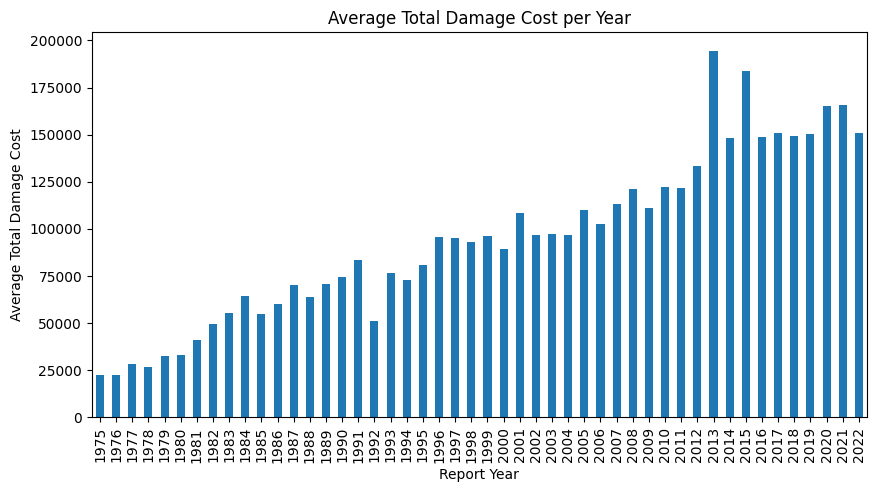

In [8]:
# Drop all rows with NA in Report Year or Total Damage Cost
df = df.dropna(subset=['Report Year', 'Total Damage Cost'])

# Convert Report Year to int
df['Report Year'] = df['Report Year'].astype(int)

# Remove commas from Total Damage Cost
df['Total Damage Cost'] = df['Total Damage Cost'].str.replace(',', '')

# Convert Total Damage Cost to int
df['Total Damage Cost'] = df['Total Damage Cost'].astype(int)

# Find average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean()

# Plot average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean().plot(kind='bar', figsize=(10, 5))
plt.title('Average Total Damage Cost per Year')
plt.xlabel('Report Year')
plt.ylabel('Average Total Damage Cost')
plt.show()


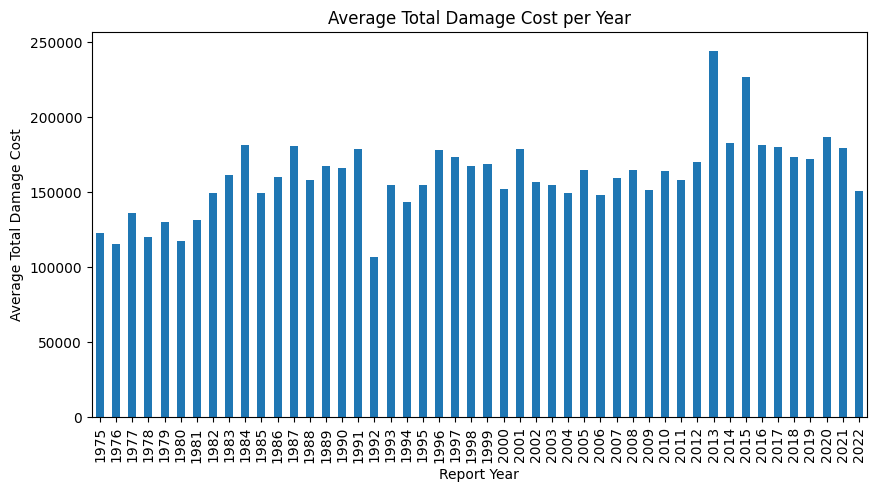

In [10]:
# Adjust for inflation
df['Total Damage Cost'] = df.apply(lambda row: cpi.inflate(row['Total Damage Cost'], row['Report Year']), axis=1)

# Find average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean()

# Plot average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean().plot(kind='bar', figsize=(10, 5))
plt.title('Average Total Damage Cost per Year')
plt.xlabel('Report Year')
plt.ylabel('Average Total Damage Cost')
plt.show()

In [20]:
# remove
# Reporting Railroad Name, Accident Year, Accident Number, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name,
# Maintenance Accident Year, Maintenance Accident Month, Maintenance Accident Number, Grade Crossing ID, Date, Subdivision, Division Code, Division, State Abbreviation,
# Track Name, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3,
# First Car Initials, First Car Number, Causing Car Initials, Causing Car Number, Narrative, Incident Key, Report Key, Reporting Railroad SMT Grouping,
# Other Railroad SMT Grouping, Maintenance Railroad SMT Grouping, Reporting Railroad SMT Grouping Name, Other Railroad SMT Grouping Name, Maintenance Railroad SMT Grouping
df_reduced = df.drop(
    [
        "Reporting Railroad Name",
        "Accident Year",
        "Accident Number",
        "Other Railroad Name",
        "Other Accident Number",
        "Other Accident Year",
        "Other Accident Month",
        "Maintenance Railroad Name",
        "Maintenance Accident Year",
        "Maintenance Accident Month",
        "Maintenance Accident Number",
        "Grade Crossing ID",
        "Date",
        "Subdivision",
        "Division Code",
        "Division",
        "State Abbreviation",
        "Track Name",
        "Adjunct Code 1",
        "Adjunct Code Name 1",
        "Adjunct Code 2",
        "Adjunct Code Name 2",
        "Adjunct Code 3",
        "Adjunct Code Name 3",
        "First Car Initials",
        "First Car Number",
        "Causing Car Initials",
        "Causing Car Number",
        "Narrative",
        "Incident Key",
        "Report Key",
        "Reporting Railroad SMT Grouping",
        "Other Railroad SMT Grouping",
        "Maintenance Railroad SMT Grouping",
        "Maintenance Railroad SMT Grouping",
    ],
    axis=1,
)

C:\Users\Gian\AppData\Local\Temp\ipykernel_7560\2420113797.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_reduced.corr()


<Axes: >

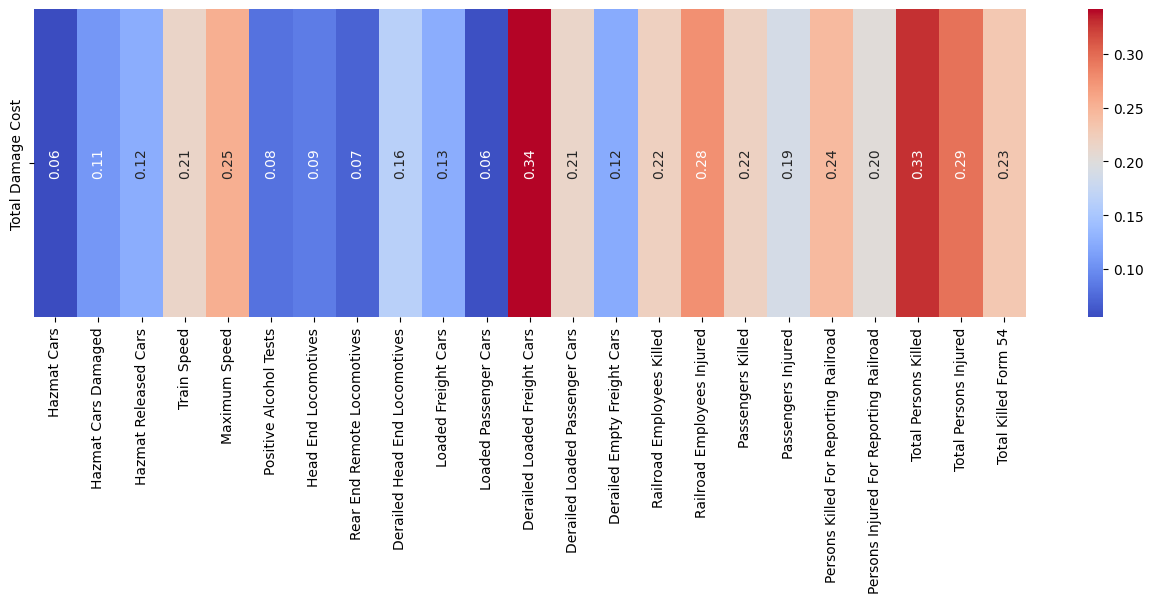

In [53]:
# Over time has Total Damage Cost decreased? And what has caused this decrease?

# correlation matrix
corr = df_reduced.corr()
# only show correlation row for Total Damage Cost
corr = corr[['Total Damage Cost']]
# print(corr)

# remove Total Damage Cost from the correlation matrix
corr = corr.drop('Total Damage Cost', axis=0)

# flip the correlation matrix
corr = corr.transpose()

cor_val = 0.05
# remove any values that have an absolute value less than cor_val
corr = corr[(corr > cor_val) | (corr < -cor_val)]
corr = corr.dropna(axis=1)

# make the seaborn plot bigger
plt.figure(figsize=(16, 4))

# plot the heatmap with the annotation values rotated vertical using annot_kws
sns.heatmap(corr, annot=True, annot_kws={"rotation": 90}, fmt=".2f", cmap="coolwarm", yticklabels=True)